In [53]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics, neighbors, preprocessing

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)

 
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import seaborn as sns
%matplotlib inline  

# Clasificación de accidentes cardiovasculares

## Información sobre el dataset

De acuerdo a la Organización Mundial de la Salud los derrames son la segunda causa de muerte a nivel global, responsable de aproximadamente el 11% de las muertes. Nuestra intención con este trabajo es poder clasificar si un individuo podría llegar a tener o ha tenido un derrame cerebral para poder tratar este tipo de casos con mayor facilidad. Gracias al conjunto de datos    [**Stroke Prediction Dataset**](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset) obtenido en [**kaggle**](https://www.kaggle.com/) hemos podido plantear este problema de clasificación. A continuación, trataremos las características de los individuos que se tomaron para formar el conjunto de datos, todos ligados a si han tenido un derrame cerebral o no. 

 **Caracteristicas** : 

*  **ID**: Número que identifica a cada individuo de manera única
*  **Gender**: Género del individuo, sus posibles valores son "Male", "Female" or "Other"
*  **Age**: Edad del individuo
*  **hypertension**: 0 si el individuo no tiene hipertensión, 1 si el individuo si tiene hipertensión
*  **heart_disease**: 0 si el individuo no ha tenido ningún ataque al corazón, 1 si el individuo ha tenido algún ataque al corazón
*  **ever_married**: "Yes" si el individuo está casado, "No" si el individuo no está casado
*  **work_type**: Tipo de oficio del individuo, sus posibles valores son "children", "Govt_jov", "Never_worked", "Private" o "Self-employed"
*  **Residence_type**: Tipo de residencia del individuo, sus posibles valores son "Rural" o "Urban"
*  **avg_glucose_level**: Nivel medio de glucosa en sangre del individuo
*  **bmi**: Indice de masa corporal (IMC) del individuo
*  **smoking_status**: Estatus de fumador del individuo, sus posibles valores son "formerly smoked", "never smoked", "smokes" or "Unknown"
*  **stroke**: 1 si el individuo ha tenido derrame cerebral o 0 si no ha tenido derrame cerebral

Una vez hemos tratado la base del problema proseguimos con la resolución de este. Para ello en este trabajo nos centraremos en las técnicas de preparación de datos para mejorar la calidad del dataset y no tanto en las técnicas de extracción de conocimiento de datos.

## Lectura de Datos

 Comenzamos nuestro problema cargando el conjunto de datos desde el fichero *healthcare-dataset-stroke-data*, el cual modificaremos a lo largo del trabajo para lograr nuestro objetivo.


In [2]:
data=pd.read_csv('./healthcare-dataset-stroke-data.csv',sep=',')#cargamos el conjunto de datos

## Transformación de variables categóricas

 Una vez hemos cargado nuestro dataset, debemos tener en cuenta que algunas de las características que hemos tratado en el primer apartado no son numéricas. Por ende, nuestro algoritmo de clasificación no podra tratar este tipo de variables nominales. Por lo tanto, debemos transformar estar variables categóricas en variables numéricas para poder trabajar con el conjunto de datos.
 
  Mostramos algunos de los datos de nuestro dataset para observar cuales son las variables categóricas y numéricas.

In [3]:
data.head()#visualizamos los primeros cinco datos del dataset

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  

Es facil de observar que las variables *gender, ever_married, work_type, Residence_type* y *smoking_status* son variables categóricas con las que nuestro algoritmo de aprendizaje no podrá tratar el problema de clasificación.

Por ello, a continuación hacemos uso del método de transformación de variables **One Hot** con el que crearemos nuevas variables binarias a partir de las variables categóricas dadas (una para cada valor de la variable categórica).

In [4]:
from sklearn.preprocessing import LabelBinarizer
## Transformación de variables categóricas

#Separamos nuestro conjunto de datos en variables categoricas y numericas
data_num=data.select_dtypes(exclude='object') #Variables numericas
data_cat=data.select_dtypes(include='object') #Variables categoricas
    
data_cat_transform=[] #Lista en la que guardaremos las nuevas variables creadas con el metodo ONE HOT en base a las categoricas dadas

for label in data_cat.columns:#procedemos a transformar las variables categoricas con ONE HOT
    
        lb = LabelBinarizer()        
        lb_results = lb.fit_transform(data_cat[label])
        
        if lb_results.shape[1]>2:
            nombres_nuevas_variables = list(map(lambda x: label + x, lb.classes_))#tenemos mas de dos etiquetas en la variable categorica
        else:
            clase=data_cat[label][0]
            nombres_nuevas_variables=[label+clase]#tenemos solo dos etiquetas en la variable categorica
        
        
        lb_results_train = pd.DataFrame(lb_results, columns=nombres_nuevas_variables)   
    
        data_cat_transform.append(lb_results_train)
        
data_cat=pd.concat(data_cat_transform,axis=1)#Concatenamos todas las variables creadas las cuales hacen referencia a todas las categoricas

data_transform=pd.concat([data_cat.reset_index(drop=True),data_num.reset_index(drop=True)],axis=1) #Concatenamos con el resto de variables numericas y obtenemos nuestro conjunto de datos transformado
print('Dimensión del dataset incial: {}\nDimensión del dataset transformado: {}'.format(data.shape,data_transform.shape))#Imprimimos las dimensiones del nuevo dataset y el antiguo

Dimensión del dataset incial: (5110, 12)
Dimensión del dataset transformado: (5110, 21)


Observamos que hemos creado 9 variables mas de las que teniamos en nuestro dataset transformado tal y como se esperaba con **One Hot**. A continuación, mostramos el conjunto de datos transformado para poder visualizar que la transformación se ha evaluado correctamente.

In [5]:
data_transform.head()#volvemos a visualizamos los primeros cinco datos del dataset para observar las nuesvas variavles

   genderFemale  genderMale  genderOther  ever_marriedYes  work_typeGovt_job  \
0             0           1            0                1                  0   
1             1           0            0                1                  0   
2             0           1            0                1                  0   
3             1           0            0                1                  0   
4             1           0            0                1                  0   

   work_typeNever_worked  work_typePrivate  work_typeSelf-employed  \
0                      0                 1                       0   
1                      0                 0                       1   
2                      0                 1                       0   
3                      0                 1                       0   
4                      0                 0                       1   

   work_typechildren  Residence_typeUrban  smoking_statusUnknown  \
0                  0          

<a name="item1"></a>
## Análisis exploratorio de datos

Una vez hemos transformado las variables parece que podemos comenzar con la primera evaluación de nuestro dataset. Sin embargo, nos encontramos con otro obstáculo. Nuestro dataset tiene varios valores nulos en algunas de las características que hacen que esos datos no puedan ser manejados por nuestro algoritmo. Seguidamente, mostramos el número de valores nulos que nos encontramos en el dataset.

In [6]:
Nulos=data_transform.isnull().sum()#tomamos los nulos del dataset en cada variable
numNulos=Nulos.sum()#calculamos el numero de nulos totales
print('Numero de nulos totales del dataset: {}'.format(numNulos))

Numero de nulos totales del dataset: 201


Observamos que 201 datos contienen alguna característica con valor nulo, lo que hace que esos datos no puedan aportar a la resolución del problema. Una solución para poder continuar con el problema sería eliminar todos estos datos que no nos permiten continuar. Sin embargo, consideramos que estos datos tienen gran información para aportar por lo que esta opción la deshechamos. En consecuencia, procedemos hacer un análisis exhaustivo de los valores nulos de nuestro conjunto de dataset y aplicar alguna de las técnicas de imputación conocidas.

Para resolver este problema, en esos valores nulos plantearemos el método de **imputación por media condicionada**. 

Para ello analizaremos la correlación las variables que contengan valores nulos con el resto de varibales para poder encontrar una imputación correcta correspondiente a cada dato. Sin embargo, antes de analizar la correlación entre variables eliminaremos de nuestros datasets la variable *id* debido a que esta variable hace referencia a la identificación de cada individuo y no aporta ninguna información a nuestro problema.

In [7]:
data.drop(data.columns[0], axis=1, inplace=True)#eliminamos del conjunto de datos inicial la variable id
data_transform.drop('id', axis=1, inplace=True)#eliminamos del conjunto de datos transformado la variable id (este sera el conjunto de datos que iremos debido a que es el utilizaremos)

No obstante, al hacer uso de la técnica de **imputación por media condicionada** nos damos cuenta que el conjunto de datos puede contener valores anomalos en las variables, las cuales estaran alterando el valor de la media que imputamos y en consiguiente nuestra imputación no sera del todo correcta. Por lo tanto, es necesario detectar y eliminar estos datos, es decir, es procedemos con el análisis de **outliers** de nuestro dataset.

<a name="item2"></a>
## Outliers

#### Reparto de datos

Comenzamos haciendo la partición de los datos, modificamos únicamente nuestro conjunto de entrenamiento (solo modificamos el *train*) de cara obtener una mejor generalización en nuestro conjunto de testeo.

Para ello detectamos y eliminamos los *outliers* de nuestros &#8220;datos de entrenamiento&#8221;. Estos datos contienen características considerablemente diferentes que provocan fallos en el proceso de aprendizaje y puede conllevar grandes problemas si los datos se normalizan en el futuro o se usan para hacer imputación por media en valores nulos tal y como hemos comentado.

In [8]:
from sklearn import model_selection

X_train, X_test, y_train, y_test =model_selection.train_test_split(data_transform.iloc[:,:-1],data_transform.iloc[:,-1],
                                                        train_size=0.75, random_state=42)

#### Detección y eliminación de outliers

Una vez hemos hecho la particion de nuestro dataset en *train* y *test*, detectaremos y eliminaremos los outliers del conjunto de entrenamiento haciendo uso del metodo basado en el rango intercuartílico, dado que es el método mas robusto que conocemos.

In [9]:
# Para calcular el IQR y los "putnos de corte" utilizamos el método describe y accedemos a los campos apropiados
#Definimos la funcion para detectar outliers
def deteccionOutilers_IQR(data, k=1.5):
    resumen=data.describe()
    IQR=resumen.loc['75%']-resumen.loc['25%']
    l1=data>(k*IQR+resumen.loc['75%'])
    l2=data<(-k*IQR+resumen.loc['25%'])
    return np.logical_or(l1,l2)

A la hora de detectar outliers en nuestro conjunto de datos sabemos que no todas las variables de nuestros datos nos interesan, es decir, solo nos fijaremos en las variables númericas continuas del dataset y no las que hacen referencia a variables cualitativas.

Por lo tanto, únicamente analizaremos las variables *bmi*, *age* y *avg_glucose_level*. Para ello, comenzaremos observando la distribución de estas variables a traves de diagramas de cajas y de histogramas y iremos detectando los outliers a eliminar.

**bmi**

Comenzamos analizando la variable **bmi** a través de su un diagrama de cajas y un histograma para visualizar su distribución. Sin emabargo, no nos podemos olvidar que hay valores nulos en esta variable con lo cual estos datos no se tendrán en cuenta en a la hora de analizar la distribución de la variable y detectar los posibles *outliers* (*comentar que python en las funciones utilizadas para mostrar las gráficas y hacer uso de funciones como describe no tiene en cuenta los valores nulos*).

<AxesSubplot:xlabel='bmi', ylabel='Count'>

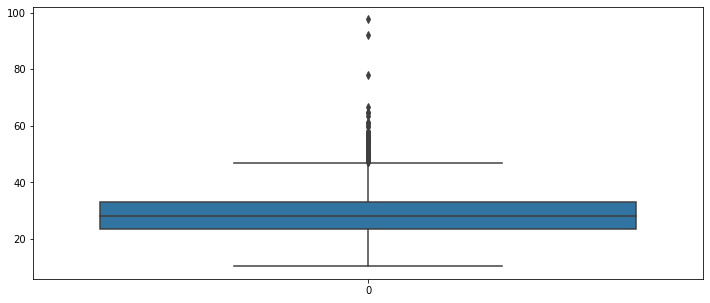

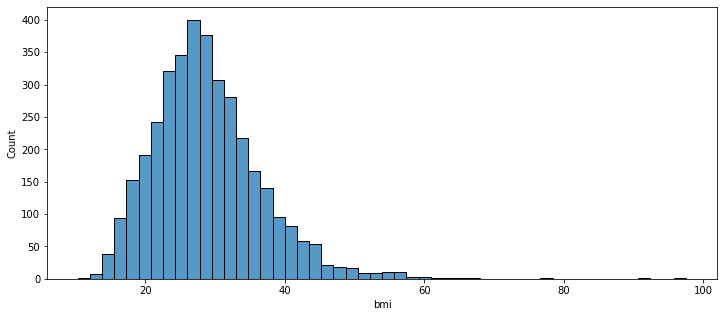

In [10]:
#distribución del bmi con un diagrama de cajas y un histograma
plt.figure(figsize=(12,5))
sns.boxplot(data=X_train['bmi'])

plt.figure(figsize=(12,5))
sns.histplot(data=X_train['bmi'], bins=50)

Observamos que hay unos cuantos valores que sobrepasan por bastante el nivel normal de ICM. Por lo que, ahora analizaremos cuantos de esos datos con aparencia anomala son *outliers* y los almacenaremos para eliminarlos una vez finalizado el análisis.

In [11]:
outliers_IQR_ibm=deteccionOutilers_IQR(X_train['bmi'],3.5)##detectamos los outliers MUY EXTREMOS en el ibm
print('Numero de outliers detectados con la tecnica de IQR: ',outliers_IQR_ibm.sum())

print('Visualizamos caules son los outliers\n{}'.format(X_train['bmi'][outliers_IQR_ibm]))

Numero de outliers detectados con la tecnica de IQR:  4
Visualizamos caules son los outliers
4209    92.0
1559    66.8
2128    97.6
928     78.0
Name: bmi, dtype: float64


Detectamos una cantidad de 8 *outliers* en la variable **ibm** los cuales eliminaremos al final del proceso.

**avg_glucose_level**

Continuamos con la variable **avg_glucose_level** y pocedemos a hacer el mismo análisis que con la variable **ibm**.

<AxesSubplot:xlabel='avg_glucose_level', ylabel='Count'>

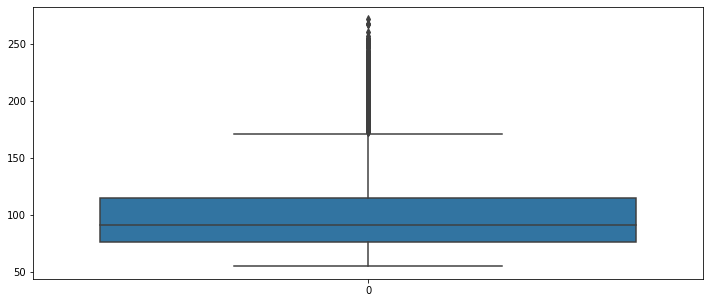

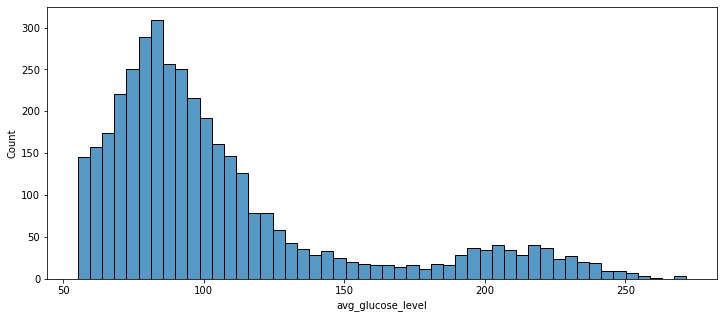

In [12]:
#distribución del avg_glucose_level con un diagrama de cajas y un histograma
plt.figure(figsize=(12,5))
sns.boxplot(data=X_train['avg_glucose_level'])

plt.figure(figsize=(12,5))
sns.histplot(data=X_train['avg_glucose_level'], bins=50)

Observamos que tenemos algunos niveles de glucosa demasiado elevados en la distribución, por lo que es probable que encontremos algunos *outliers*.

In [13]:
outliers_IQR_avg_glucose_level=deteccionOutilers_IQR(X_train['avg_glucose_level'],3.5)##detectamos los outliers MUY EXTREMOS en el avg_glucose_level
print('Numero de outliers detectados con la tecnica de IQR: ',outliers_IQR_avg_glucose_level.sum())

print('Visualizamos caules son los outliers\n{}'.format(X_train['avg_glucose_level'][outliers_IQR_avg_glucose_level]))

Numero de outliers detectados con la tecnica de IQR:  24
Visualizamos caules son los outliers
1113    251.46
755     250.20
1207    267.76
785     254.60
386     251.60
193     271.74
4447    247.87
4283    253.93
3215    260.85
1067    254.63
2293    247.48
2751    255.17
123     249.31
243     247.51
4983    267.60
552     247.69
1453    251.99
4048    247.97
3088    267.61
4470    256.74
4249    248.24
1529    253.16
2693    250.80
3342    248.37
Name: avg_glucose_level, dtype: float64


Detectamos un total de 24 *outliers*.

**age**

Finalmente, analizamos la variable *edad* siguiendo el procedimiento anterior.

<AxesSubplot:xlabel='age', ylabel='Count'>

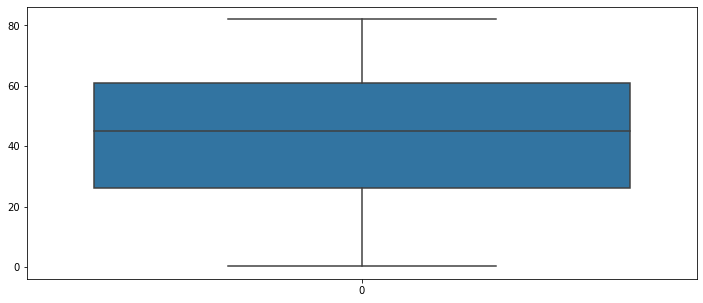

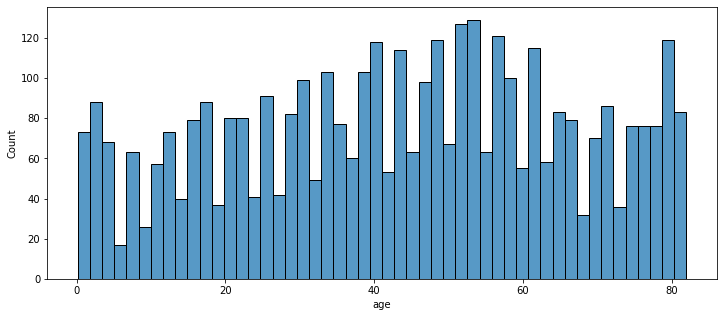

In [14]:
#distribución del age con un diagrama de cajas y un histograma
plt.figure(figsize=(12,5))
sns.boxplot(data=X_train['age'])

plt.figure(figsize=(12,5))
sns.histplot(data=X_train['age'], bins=50)

Observamos que ha simple vista no observamos en la distribución ningun dato que pueda considerarse *outlier*.

In [15]:
outliers_IQR_age=deteccionOutilers_IQR(X_train['age'],3)##detectamos los outliers MUY EXTREMOS en el age
print('Numero de outliers detectados con la tecnica de IQR: ',outliers_IQR_age.sum())

print('Visualizamos caules son los outliers\n{}'.format(X_train['age'][outliers_IQR_age]))

Numero de outliers detectados con la tecnica de IQR:  0
Visualizamos caules son los outliers
Series([], Name: age, dtype: float64)


Tal y como hemos predicho, no detectamos ningún *outlier* en esta característica.

Finalmente, tomamos todos los *outliers* detectados y procedemos a su eliminación del conjunto *train*.

In [16]:
outliers_IQR=np.logical_or(outliers_IQR_ibm,
                           np.logical_or(outliers_IQR_age,outliers_IQR_avg_glucose_level))##concatenamos todos los OUTLIERS detectados

print('Numero de outliers detectados con la tecnica de IQR: ',outliers_IQR.sum())

#Eliminamos los outliers de nuestros datos de entrenamiento
X_train_sinOut=X_train[np.logical_not(outliers_IQR)]
y_train_sinOut=y_train[np.logical_not(outliers_IQR)]

print('Número de outliers de la clase negativa',y_train[np.logical_and(y_train==0,outliers_IQR)].shape[0])
print('Número de outliers de la clase positiva',y_train[np.logical_and(y_train==1,outliers_IQR)].shape[0])

print('Al detectar y eliminar con la tecnica de IQR los outliers en la base de datos tenemos', 
      '{} datos. (Teniamos {} datos).'.format(X_train.shape[0]-outliers_IQR.sum(),X_train.shape[0]))

Numero de outliers detectados con la tecnica de IQR:  28
Número de outliers de la clase negativa 25
Número de outliers de la clase positiva 3
Al detectar y eliminar con la tecnica de IQR los outliers en la base de datos tenemos 3804 datos. (Teniamos 3832 datos).


Finalmente, observamos que detectamos un total de 28 individuos como posibles outliers de nuestros datos de entrenamiento y los eliminamos esperando una mejora de calidad de nuestro dataset. Además observamos que en la distribución de los datos no se muestran varios de los datos que se desviaban de la distribución de las variables y podían perjudicar el aprendizaje de nuestro algoritmo.

Text(0.5, 1.0, 'Age')

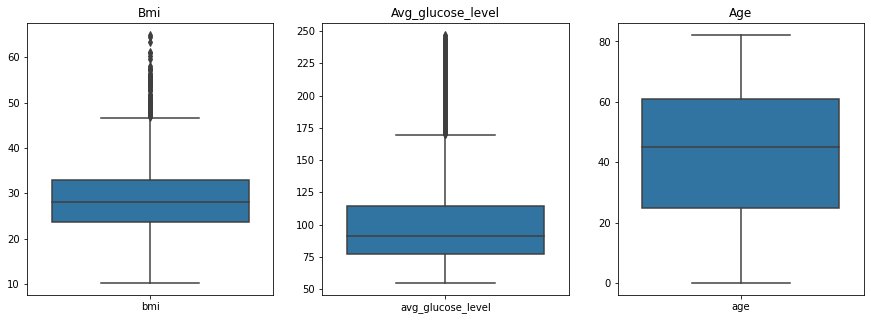

In [17]:
fig,axes=plt.subplots(ncols=3, figsize=(15,5))

sns.boxplot(ax=axes[0],data=pd.DataFrame(X_train_sinOut['bmi']))
axes[0].set_title('Bmi')

sns.boxplot(ax=axes[1],data=pd.DataFrame(X_train_sinOut['avg_glucose_level']))
axes[1].set_title('Avg_glucose_level')

sns.boxplot(ax=axes[2],data=pd.DataFrame(X_train_sinOut['age']))
axes[2].set_title('Age')

## Detección y modificación de valores nulos

Despues de detectar y eliminar los *outliers* somos capaces de resolver correctamente la imputación de valores nulos tal y como hemos explicado en el apartado [Análisis exploratorio de datos](#item1).

A continuación, tal y como hemos explicabamos procedemos a imputar mediante la técnica de **imputación por media condicionada** y mostramos la matriz de correlaciones para visualizar las variables mas correlacionadas con las características que contenga los valores nulos.

Comenzamos el análisis visualizando en que características del dataset se encuentran estos valores nulos.

In [18]:
Nulos=X_train_sinOut.isnull().sum()+X_test.isnull().sum()+y_train.isnull().sum()#observamos el numero de valores nulos en el total de nuestros datos
print(Nulos)
numNulos=Nulos.sum()
print('Numero de nulos totales del dataset: {}'.format(numNulos))

genderFemale                       0
genderMale                         0
genderOther                        0
ever_marriedYes                    0
work_typeGovt_job                  0
work_typeNever_worked              0
work_typePrivate                   0
work_typeSelf-employed             0
work_typechildren                  0
Residence_typeUrban                0
smoking_statusUnknown              0
smoking_statusformerly smoked      0
smoking_statusnever smoked         0
smoking_statussmokes               0
age                                0
hypertension                       0
heart_disease                      0
avg_glucose_level                  0
bmi                              199
dtype: int64
Numero de nulos totales del dataset: 199


Observamos que todos nuestros valores nulos se encuentran en la misma caracteristica, la correspondiente al IMC de los individuos. Por lo tanto, en esos valores nulos planteremos el método de **imputación por media condicionada** ya comentado y analizaremos la correlación de las demas variables con esta característica. 

*Comentar que en el apartado [Análisis exploratorio de datos](#item1) teniamos 201 valores nulos pero en la detección y eliminación de outliers algunos de estos los habremos eliminado*

**Visualización de la matriz de correlaciones**

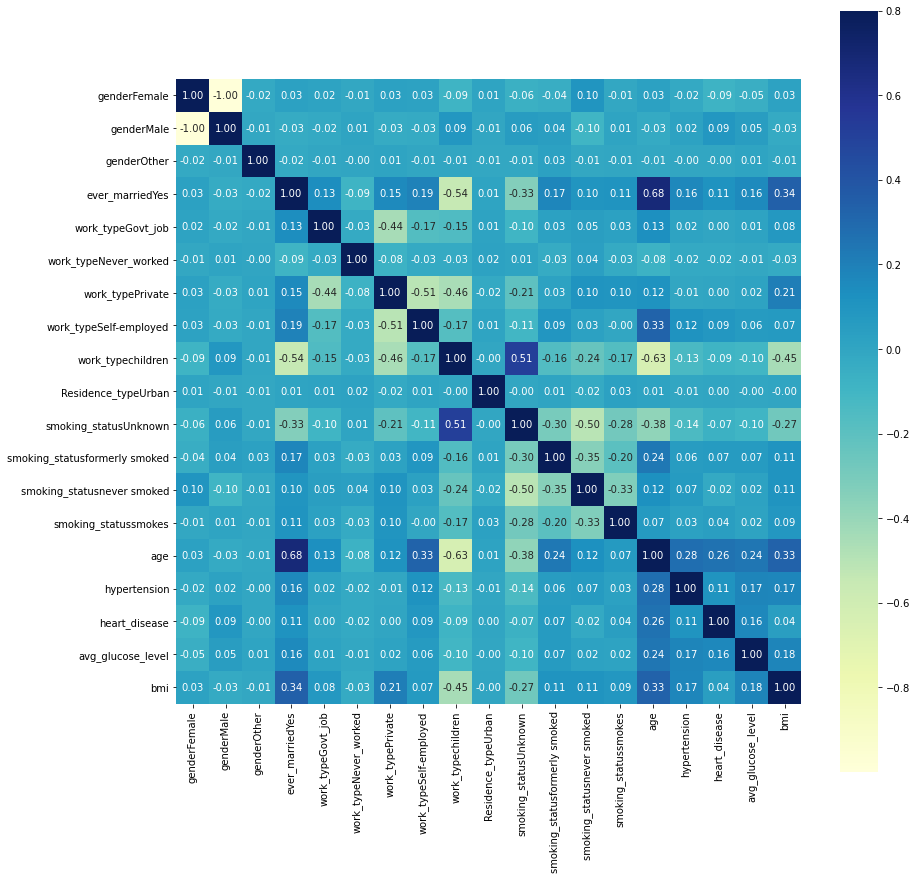

In [19]:
correlaciones_transform=pd.concat([X_train,X_test]).corr()#creamos la matriz de correlaciones
fig, axes = plt.subplots(figsize=(14,14))
sns.heatmap(correlaciones_transform, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},cmap="YlGnBu");

Gracias a la anterior matriz de correlación podemos observar que la variable *ibm* está correlacionada positivamente con la edad, con la hipertensión y con la media de glucosa en sangre del individuo. Sin embargo, no consideramos que la correlación con las variables *hypertension* y *avg_glucose_level* sea lo suficientemente alta como para considerar que hay depedencia entre ellas. 

Por otro lado, observamos que la variable *ibm* también esta altamente correlacionada positivamente con la variable *ever_marriedYes*, por lo que consideremos que hay una relación entre ellas. Sin embargo, observamos que existe una correlación positiva alta entre esta variable y la variable *age*, por lo tanto, no tiene sentido tener ambas en cuenta a la hora de hacer la imputación dada la correlación entre ambas.

Finalmente, planteamos un análisis para las dos posibles variables y decidimos considerar únicamente uno de los dos factores con el fin de imputar los valores nulos del ICM.

Como ya hemos comentado observamos una correlación positiva entre la edad y el ICM por lo que vamos observar la variación de la media de la variable *ibm* entre 4 grupos de edades. Los grupos de edades se basan en:

* Muy jóvenes: de 0 a 14 años
* Jóvenes: de 15 a 30 años
* Mayores: de 31 a 60 años
* Muy mayores: a partir de 60 años 

<AxesSubplot:xlabel='bmi', ylabel='Count'>

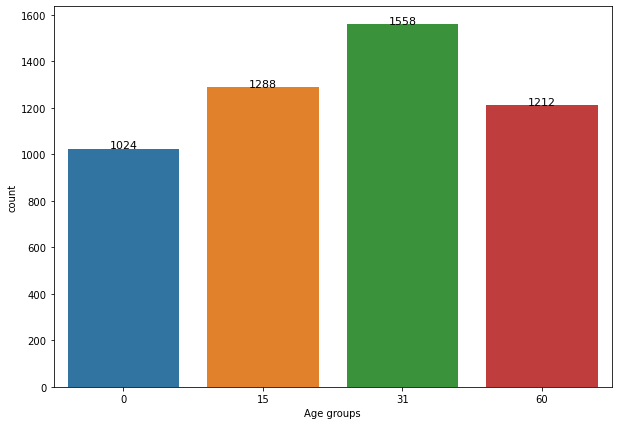

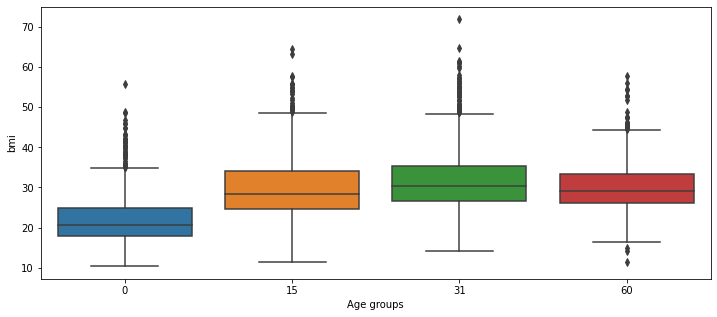

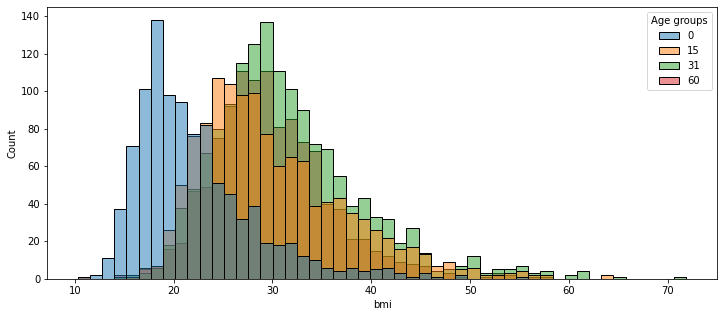

In [20]:
data_age=pd.concat([X_train_sinOut,X_test]).copy()#copiamos el conjunto de datos y definimos uno en el que crearemos la particion de edades
data_age['Age groups']=pd.cut(data.age,4, labels=[0,15,31,60])#agrupamos por cada grupo de edad

countplt, ax = plt.subplots(figsize = (10,7))
ax =sns.countplot(x='Age groups', data=data_age);#mostramos la cantidad de individuos que contiene cada grupo de edad
# show count (+ annotate)
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)


plt.figure(figsize=(12,5))
sns.boxplot(y='bmi', x='Age groups' ,data=data_age)#mostramos la ditribucion del ICM en cada grupo de edad con diagramas de caja

plt.figure(figsize=(12,5))
sns.histplot(x='bmi', hue='Age groups', data=data_age, bins=50)#mostramos la ditribucion del ICM en cada grupo de edad a traves de un histograma

Observamos que tenemos mayor cantidad de individuos *Mayores* en el conjunto de datos que en el resto grupo de edades aunque no consideramos que haya una gran diferencia, asimismo tenemos una cantidad suficiente de individuos en cada grupo por lo que no estaremos provocando ninún sesgo a la hora de imputar valores nulos.

Además, es fácil de observar gracias al diagrama de cajas que los individuos de mayor edad tienen mayor ICM medio que los de edad mas temprana. Adicionalmente, analizando el histograma se observa que hay mayor cantidad de *Mayores* en niveles altos de ICM que cualquier otro grupo de edad y que los *Muy jóvenes* toman mayoritariamente niveles bajos de ICM excepto alguna excepción.

En consecuencia, planteamos que no es correcto imputar una media del ICM sobre todos los valores perdidos y habría que diferenciar entre grupos de edades la dada la diferencia de valores que toman en esta carcaterística y la diferencia de número de individuos que hay para cada grupo de edad.

Por otro lado, hemos comentado que la variable *ibm* también estaba correlacionada positivamente con la variable *ever_marriedYes* por lo que recreamos el análisis anterior en este caso para obtener información.

<AxesSubplot:xlabel='bmi', ylabel='Count'>

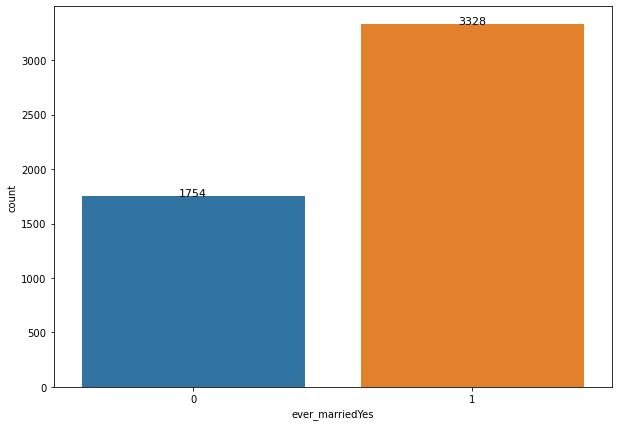

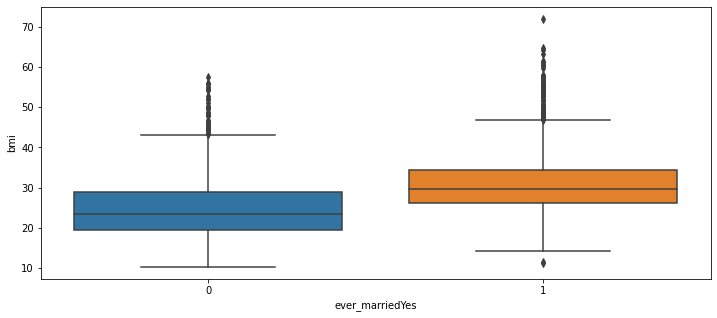

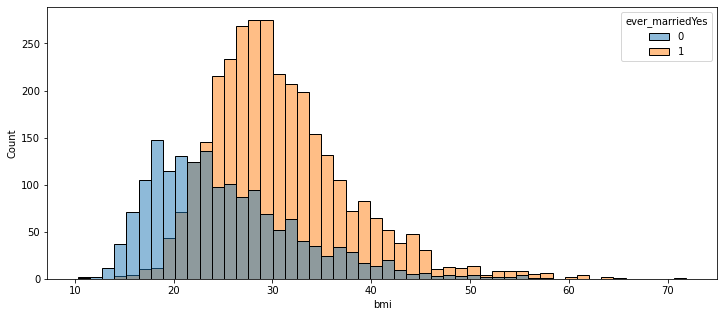

In [21]:
countplt, ax = plt.subplots(figsize = (10,7))
ax =sns.countplot(x='ever_marriedYes', data=data_age);#mostramos la cantidad de individuos que contiene cada estado civil
# show count (+ annotate)
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

plt.figure(figsize=(12,5))#mostramos la ditribucion del ICM en cada estado civil con diagramas de caja
sns.boxplot(y='bmi', x='ever_marriedYes' ,data=data_age)

plt.figure(figsize=(12,5))#mostramos la ditribucion del ICM en cada estado civil con un histograma
sns.histplot(x='bmi', hue='ever_marriedYes', data=data_age, bins=50)

Se observa que tenemos un caso similar a la relación entre el *ibm* y los grupos de edades. Tenemos una diferencia entre la cantidad de individuos casados y no casados significativa pero tenemos suficientes individuos en cada grupo por lo que no provocaremos sesgos ni obstaculos en la imputación. Observamos que la media y los valores de IMC que toman los individuos casados es mas alto que los que estan solteros. Por lo que consideramos que no sería correcto imputar un mismo valor para individuos casados y solteros.

Mostramos las medias agrupadas por grupos de edad y agrupadas por casado o soltero para corroborar nuestra hipótesis.

In [22]:
print(data_age.groupby(['Age groups'])['bmi'].mean(),'\n')
print(data_age.groupby(['ever_marriedYes'])['bmi'].mean(),'\n')

Age groups
0     22.128128
15    30.043965
31    31.531312
60    29.833569
Name: bmi, dtype: float64 

ever_marriedYes
0    25.142244
1    30.807608
Name: bmi, dtype: float64 



Observamos que lo concluido anteriormente tiene sentido y, por lo tanto, habría que imputar una media distinta para cada grupo de los analizados. Como ya hemos comentado solo haremos uso de una de las variables dada su correlación, en este consideramos que la variable *ever_marriedYes* es la correcta dado que observamos una clara diferencia de medias entre los individuos casados y los no casados (además que aunque la diferencia sea minima el estado civil tiene una mayor correlación con el ICM que la edad). Sin embargo, también se podría a llegar a imputar por la variable *age*.

Por lo tanto, procedemos a introducir la media por el estado civil en los valores faltantes.

In [23]:
medias=data_age.groupby(['ever_marriedYes'])['bmi'].mean()#calculamos las medias agrupadas por el estado civil

#imputamos las medias segun su estado civil en nuestros datos
X_train_sinOut['bmi'][np.logical_and(data_age['ever_marriedYes']==0,data_age['bmi'].isnull())]=medias[0]
X_test['bmi'][np.logical_and(data_age['ever_marriedYes']==0,data_age['bmi'].isnull())]=medias[0]
X_train_sinOut['bmi'][np.logical_and(data_age['ever_marriedYes']==1,data_age['bmi'].isnull())]=medias[1]
X_test['bmi'][np.logical_and(data_age['ever_marriedYes']==1,data_age['bmi'].isnull())]=medias[1]

C:\Users\unaig\AppData\Local\Temp/ipykernel_9268/1477895642.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_sinOut['bmi'][np.logical_and(data_age['ever_marriedYes']==0,data_age['bmi'].isnull())]=medias[0]
C:\Users\unaig\anaconda3\envs\py38ml\lib\site-packages\pandas\core\generic.py:8861: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
C:\Users\unaig\AppData\Local\Temp/ipykernel_9268/1477895642.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

Una vez hemos imputado los valores, nos aseguramos que hemos imputado todos los valores correctamente y no contenemos ningun valor nulo en nuestro conjunto de datos.

In [24]:
Nulos=X_train_sinOut.isnull().sum()+X_test.isnull().sum()
numNulos=Nulos.sum()
print(Nulos)
print('Numero de nulos totales del dataset: {}'.format(numNulos))

genderFemale                     0
genderMale                       0
genderOther                      0
ever_marriedYes                  0
work_typeGovt_job                0
work_typeNever_worked            0
work_typePrivate                 0
work_typeSelf-employed           0
work_typechildren                0
Residence_typeUrban              0
smoking_statusUnknown            0
smoking_statusformerly smoked    0
smoking_statusnever smoked       0
smoking_statussmokes             0
age                              0
hypertension                     0
heart_disease                    0
avg_glucose_level                0
bmi                              0
dtype: int64
Numero de nulos totales del dataset: 0


Efectivamente, tal y como hemos tratado actualmente no tenemos ningún valor nulo en nuestro conjunto de datos (ni en *train* ni en *test*).

Además, comentar que tampoco tenemos ningún *outlier* en el conjunto de entrenamiento dado que los hemos eliminados en el apartado [Outliers](#item2). Es cierto, que se puede llegar a pensar que en la imputación de valores nulos hemos podido crear algún *outlier* en *train*; sin embargo, gracias a la técnica de imputación tratada en base a las medias no hemos introducido ningún valor anomalo que se salga de la distribución de la variable.

## 1.Generalización

Una vez hemos repartido y adecuado nuestro dataset para poder entrenar y testear nuestro modelo de clasificación, iteramos por primera vez con el algoritmo de aprendizaje para analizar los resultados obtenidos.

In [25]:
# Se importa de la libreria scikit-learn de python (sklearn) el paquete correspondiente a la regresión lineal
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression(penalty='l2',max_iter=400,solver='newton-cg',C=10.e50)
LogReg=LogReg.fit(X_train_sinOut,y_train_sinOut.ravel())

# Cálculo de la media geométrica en test
predicciones=np.round(LogReg.predict_proba(X_test.to_numpy())[:,1].reshape(-1,1),0)
comparacion= predicciones==y_test.to_numpy().reshape(-1,1)   
suma=comparacion.sum()
accTest=100*suma/predicciones.size
print('Accuracy obtenido con el conjunto de datos sin modificar: {}'.format(accTest))

Accuracy obtenido con el conjunto de datos sin modificar: 93.81846635367762


Comenzamos con un accuracy con un valor alto el cual podemos pensar que este conjunto de datos no hace falta modificarlo en gran medida para el problema de clasificación planteado. Sin embargo, a nosotros nos interesa saber cuantos accidentes cardiovasculares podemos predecir en base a nuestro algoritmo, observemos cuantos accidentes de estos somos capaces de predecir en nuestro conjunto *test* a generalizar:

In [26]:
print('Numero de accidentes cerebrovasculares predecidos: ',predicciones.sum())
print('Numero de accidentes cerebrovasculares "reales": ',y_test.sum())

Numero de accidentes cerebrovasculares predecidos:  1.0
Numero de accidentes cerebrovasculares "reales":  80


Observamos que en nuestro conjunto de datos *test* hay un total de 80 inidividuos que sufrieron un accidente cardiovascular y entre estos solo hemos sido capaces de detectar **uno!** Entonces, ¿el accuracy nos sirve como parámetro de medida? En nuestro punto de vista no, debido a que tenemos una gran muestra de individuos que no han sufrido este tipo de accidentes (*clase negativa*) y una muestra muy pequeña de individuos que si han sufrido estos accidentes (*clase positiva*). En consecuencia, nuestro algoritmo de clasificación es sobre entrenado con individuos de la *clase negativa*, es decir, el dataset no esta balanceado. Por ende, predice casi siempre individuos que no van a sufrir un accidente y al ser la clase mayoritaria acierta en muchas ocasiones y por ello obtenemos un accuracy tan elevado.

Sin embargo, a nosotros nos interesa que cualquier individuo sea consciente de que puede llegar a sufrir un accidente de este tipo aunque se de el caso de obtener un falso positivo para amparar el bienestar de los individuos. Por lo tanto, basamos la calidad de nuestro algorimto de clasificación en la mejor del **RECALL**.

In [27]:
from sklearn.metrics import recall_score,precision_score,confusion_matrix

precision1 = precision_score(y_test, predicciones)##PRECISION
recall1 = recall_score(y_test, predicciones)##RECALL
matriz_de_decision=confusion_matrix(y_test, predicciones)##MATRIZ DE DECISION

print('Precisión de nuestro modelo',precision1)
print ('Recall de nuestro modelo ', recall1)

Precisión de nuestro modelo 1.0
Recall de nuestro modelo  0.0125


Como ya hemos comentado nuestro modelo tiene un buen accuracy y una precisión muy buena; sin emabrgo, es facil de observar que obtenemos un **recall** muy bajo con el que no conseguimos detectar los individuos de la *clase positiva*. A continuación, mostramos la matriz de decisión donde se visualiza que no tenemos ningún falso positivo pero tenemos muchos falsos negativos y a nosotros nos interesa mas tener mas falsos positivos y pocos falsos negativos de cara a proteger la salud de los individuos.

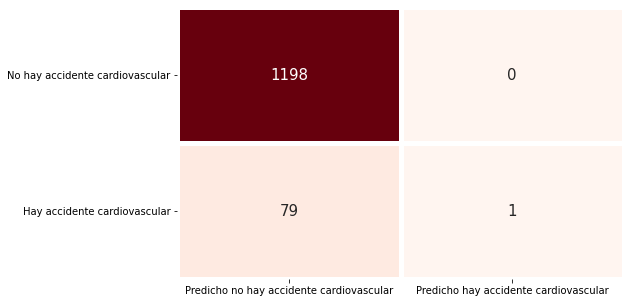

In [28]:
plt.figure(figsize = (8, 5))
sns.heatmap(matriz_de_decision, cmap = 'Reds', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No hay accidente cardiovascular', 'Hay accidente cardiovascular'],
            xticklabels = ['Predicho no hay accidente cardiovascular', 'Predicho hay accidente cardiovascular'])
plt.yticks(rotation = 0)
plt.show()

Finalmente, antes de seguir modificando nuestro conjunto de datos para lograr una mejora en el recall, debemos tener cuidado dado que una gran mejora del recall nos puede llevar a una precisión muy baja y, en consecuencia, tener una gran cantidad de falsos positivos (algo que tampoco es apropiado poruq puede tener consecuencias como la saturación del servicio sanitario).

Para ello, aparte de dirigir nuestro objetivo en la mejora del recall, también nos centraremos en mantener y lograr un **F Score** apto (teniendo en cuenta que favoreceremos el recall ante la precisión).

A continuación, creamos la función correspondiente donde tomaremos el recall y la precisión para obtener el balance de ambos, donde tendremos que tener en cuenta el parametro B con el que favoreceremos el recall si lo aumentamos y lo perjudicaremos si lo reducimos. Si no seleccionamos ningún valor, B tendra el valor 1 predeterminado, es decir, el **F Score** tradicional.

In [29]:
#definimos la función F_Score
def F_Score(recall, precision, B=1):
    return (1+B**2)*(precision*recall)/((precision*B**2)+recall)

Una vez hemos definido el **F Score**, calculamos el balance entre la precisión y el recall con un *B=2* con esta primera iteración. 

In [30]:
f1=F_Score(recall1,precision1,2)
print('F_Sore de nuestro modelo ',f1)

F_Sore de nuestro modelo  0.01557632398753894


Observamos que tenemos un **F Score** de mala calidad debido a al bajo valor del recall en nuestro modelo. Visto esto, nos centraremos en seguir modificando nuestro conjunto de datos en busca de obtener una mejora en el **F Score** (teniendo en cuenta que priorizamos el recall respecto la precisión).

<a name="item3"></a>
## Selección de instancias y balanceo del modelo

Continuamos con la selección de instancias del modelo. Es necesario comentar que a parte de obtener un subconjunto de instacias del modelo para lograr una solución menos compleja y mas simple, tenemos un conjunto de datos desbalanceado; por lo tanto, a parte de hacer uso de técnicas de **undersampling** también haremos uso de técnicas de **oversampling** o **híbridas** con el objetivo de seleccionar las instancias relevantes (con la intención de eliminar instancias superfluas y el ruido del dataset) y creando si es necesario instancias artificiales (instancias que ayudaran a balancear el conjunto de datos de entrenamiento). 

*En este apartado solo modificamos train dado que es el conjunto de datos que usamos para entrenar, test no lo modificamos.*

A continuación, mostramos que el obstáculo del desbalanceo del conjunto de datos es notorio:

* *Clase positiva*: 35 individuos
* *Clase negativa*: 1178 individuos

C:\Users\unaig\anaconda3\envs\py38ml\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


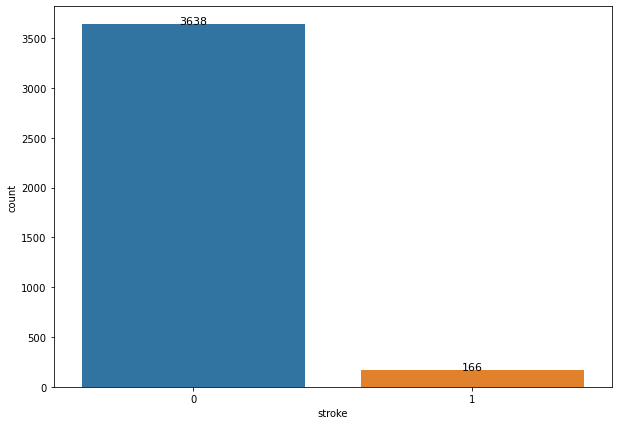

In [31]:
countplt, ax = plt.subplots(figsize = (10,7))
ax =sns.countplot(y_train_sinOut);

# show count (+ annotate)
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

Realizamos distintas técnicas de **undersampling**,**oversampling** y **híbridas** para modificar nuestro conjunto de entrenamiento y obtenemos el que mejor resultado nos de respecto a nuestro objetivo (la mejora del **F score priorizando el recall**). Haremos uso de las siguientes técnicas:

*  Tomek Links
*  Smote
*  OSS
*  NCL
*  Smote con Tomek Links
*  Smote con ENN


Comentar que crearemos dos conjuntos de datos de entrenamiento, uno con los datos estandarizados y otros sin estandarizar, dado que la estandarización de los datos de entrenamiento puede hacer variar la selección y creación de instancias ya que normaliza los rangos de las distintas variables. Esta diferencia de rangos entre variables puede provocar que se les de mas importancia de la que merecen a algunas instancias que a otras, por ello creemos que la mejor opción la obtenndremos con la normalización de los datos.

Comenzamos evaluando todas las técnicas con los datos sin normalizar y tomaremos la mejor técnica. Posteriormente, repetiremos el proceso con los datos normalizados y finalmente compararemos los resultados y seleccionaremos el que mejor resultado nos ofrezca en base a nuestro objetivo.

In [32]:
from sklearn import neighbors
from imblearn.metrics import geometric_mean_score
from imblearn.pipeline import Pipeline
import imblearn.combine as hib
import imblearn.under_sampling as us
import imblearn.over_sampling as os

#tecnicas de muestreo
tl = us.TomekLinks()
smote = os.SMOTE(random_state = 42)
oss = us.OneSidedSelection(random_state = 42)
ncl = us.NeighbourhoodCleaningRule()
smoteTomek = hib.SMOTETomek(random_state = 42)
smoteEnn = hib.SMOTEENN(random_state = 42)


listaMetodos = ['Técnica OSS', 'Técnica NCL', 'Técnica híbrida SMOTE con Tomek Links', 'Técnica híbrida SMOTE con ENN', 'Técnica Tomek Links', 'Técnica SMOTE']
listaTecnicas = [oss, ncl, smoteTomek, smoteEnn, tl, smote]

print('USO DE DATOS SIN ESTANDARIZAR\n')
# Se crea una lista para almacenar el resultado de test de cada técnica de
#muestreo, almacenamos el F Score de las predicciones obtenidas con nuestro clasificador
listaF_Score=[]

# Por cada técnica se cogen los datos de entrada y de salida (muestreados para realizar el aprendizaje)
for nombre, metodo in zip(listaMetodos, listaTecnicas):
    # Generamos la pipeline con los componentes adecuados
    pipe = Pipeline([(nombre,metodo),('Modelo Logistico', LogReg)])
    # Entrenamiento de la pipeline
    pipe = pipe.fit(X_train_sinOut,y_train_sinOut)
    # Precicción de los datos de entrenamiento 
    prediccionesTrain = pipe.predict(X_train_sinOut)
    # Cálculo de la media geométrica en entrenamiento
    accTrain = geometric_mean_score(y_train_sinOut, prediccionesTrain)
    # Se imprime el resultado en train: mostrad el nombre de la técnica y su rendimiento
    print('\nResultado en train utilizando la {}: Rendimiento: {}'.format(nombre,accTrain))
    # Precicción de los datos de test 
    prediccionesTest = pipe.predict(X_test)
    # Cálculo de la media geométrica en test
    accTest = geometric_mean_score(y_test, prediccionesTest)
    # Se imprime el resultado en test: mostrad el nombre de la técnica y su rendimiento
    print('Resultado en test utilizando la {}: Rendimiento: {}'.format(nombre,accTest))        
        
    
    precision = precision_score(y_test, prediccionesTest)
    recall = recall_score(y_test, prediccionesTest)
    
    # Se añade a la lista el resultado de test a la lista listaF_Score
    f_score=F_Score(recall,precision,2)
    listaF_Score.append(f_score)
    
    print('Precision obtenido en test utilizando la {}: Rendimiento: {}'.format(nombre,precision))     
    print('Recall obtenido en test utilizando la {}: Rendimiento: {}'.format(nombre,recall)) 
    print('F Score obtenido en test utilizando la {}: Rendimiento: {}'.format(nombre,f_score)) 
    
#Se podria dar el caso de que en dos o mas técnicas se obtenga el mismo F Score, en ese caso se activa
#el siguiente codigo y se desactiva la ultima linea. Despues habría que analizar con cual de las ténicas nos quedamos    
#for i in np.where(listaF_Score==max(listaF_Score))[0]:
#    print('\n\nLa mejor tecnica es : {}.'.format(listaMetodos[i]))
print('\n\nLa mejor tecnica es : {}.'.format(listaMetodos[int(np.where(listaF_Score==max(listaF_Score))[0])]))

USO DE DATOS SIN ESTANDARIZAR


Resultado en train utilizando la Técnica OSS: Rendimiento: 0.0
Resultado en test utilizando la Técnica OSS: Rendimiento: 0.11180339887498951
Precision obtenido en test utilizando la Técnica OSS: Rendimiento: 1.0
Recall obtenido en test utilizando la Técnica OSS: Rendimiento: 0.0125
F Score obtenido en test utilizando la Técnica OSS: Rendimiento: 0.01557632398753894

Resultado en train utilizando la Técnica NCL: Rendimiento: 0.20512421929813185
Resultado en test utilizando la Técnica NCL: Rendimiento: 0.19340654975762475
Precision obtenido en test utilizando la Técnica NCL: Rendimiento: 0.5
Recall obtenido en test utilizando la Técnica NCL: Rendimiento: 0.0375
F Score obtenido en test utilizando la Técnica NCL: Rendimiento: 0.046012269938650305

Resultado en train utilizando la Técnica híbrida SMOTE con Tomek Links: Rendimiento: 0.203649710355409
Resultado en test utilizando la Técnica híbrida SMOTE con Tomek Links: Rendimiento: 0.2936977140622804
Precisi

In [33]:
from sklearn import neighbors
from imblearn.metrics import geometric_mean_score
from imblearn.pipeline import Pipeline
import imblearn.combine as hib
import imblearn.under_sampling as us

print('USO DE DATOS ESTANDARIZADOS\n')

# Se crea una lista para almacenar el resultado de test de cada técnica de
#muestreo, almacenamos el F Score de las predicciones obtenidas con nuestro clasificador
listaF_Score_Norm = []

# Por cada técnica se cogen los datos de entrada y de salida (muestreados para realizar el aprendizaje)
for nombre, metodo in zip(listaMetodos, listaTecnicas):
    # Generamos la pipeline con los componentes adecuados
    pipe = Pipeline([('estandarizar',StandardScaler()),(nombre,metodo),('Modelo Logistico', LogReg)])
    # Entrenamiento de la pipeline
    pipe = pipe.fit(X_train_sinOut,y_train_sinOut)
    # Precicción de los datos de entrenamiento 
    prediccionesTrain = pipe.predict(X_train_sinOut)
    # Cálculo de la media geométrica en entrenamiento
    accTrain = geometric_mean_score(y_train_sinOut, prediccionesTrain)
    # Se imprime el resultado en train: mostrad el nombre de la técnica y su rendimiento
    print('\nResultado en train utilizando la {}: {}'.format(nombre,accTrain))
    # Precicción de los datos de test 
    prediccionesTest = pipe.predict(X_test)
    # Cálculo de la media geométrica en test
    accTest = geometric_mean_score(y_test, prediccionesTest)
    # Se imprime el resultado en test: mostrad el nombre de la técnica y su rendimiento
    print('Resultado en test utilizando la {}: {}'.format(nombre,accTest))        
        
    
    precision = precision_score(y_test, prediccionesTest)
    recall = recall_score(y_test, prediccionesTest)
    
    # Se añade a la lista el resultado de test a la lista listaF_Score_Norm
    f_score=F_Score(recall,precision,2)
    listaF_Score_Norm.append(f_score)
    
    
    print('Precision obtenido en test utilizando la {}: {}'.format(nombre,precision))     
    print('Recall obtenido en test utilizando la {}: {}'.format(nombre,recall)) 
    print('F Score obtenido en test utilizando la {}: Rendimiento: {}'.format(nombre,f_score)) 

#Se podria dar el caso de que en dos o mas técnicas se obtenga el mismo F Score, en ese caso se activa
#el siguiente codigo y se desactiva la ultima linea. Despues habría que analizar con cual de las ténicas nos quedamos
#for i in np.where(listaF_Score_Norm==max(listaF_Score_Norm))[0]:
#    print('\n\nLa mejor tecnica es : {}.'.format(listaMetodos[i]))
print('\n\nLa mejor tecnica es : {}.'.format(listaMetodos[int(np.where(listaF_Score_Norm==max(listaF_Score_Norm))[0])]))

USO DE DATOS ESTANDARIZADOS


Resultado en train utilizando la Técnica OSS: 0.07761505257063331
Resultado en test utilizando la Técnica OSS: 0.11180339887498951
Precision obtenido en test utilizando la Técnica OSS: 1.0
Recall obtenido en test utilizando la Técnica OSS: 0.0125
F Score obtenido en test utilizando la Técnica OSS: Rendimiento: 0.01557632398753894

Resultado en train utilizando la Técnica NCL: 0.20506770346311556
Resultado en test utilizando la Técnica NCL: 0.157981846339872
Precision obtenido en test utilizando la Técnica NCL: 0.5
Recall obtenido en test utilizando la Técnica NCL: 0.025
F Score obtenido en test utilizando la Técnica NCL: Rendimiento: 0.0308641975308642

Resultado en train utilizando la Técnica híbrida SMOTE con Tomek Links: 0.7747326171711871
Resultado en test utilizando la Técnica híbrida SMOTE con Tomek Links: 0.7348639613807627
Precision obtenido en test utilizando la Técnica híbrida SMOTE con Tomek Links: 0.1642651296829971
Recall obtenido en test util

Una vez hemos obtenido las mejores técnicas con los datos **sin normalizar** y los datos **normalizados**. Comparamos los resultados como ya hemos dicho para saber cual de las dos técnicas es mejor.

In [34]:
from sklearn.preprocessing import StandardScaler

#Mostramos la informacion de las mejores técnicas y sus F Score con los datos con o sin normalizar
print('La mejor técnica con los datos sin normalizar es {} con un F Score de {}.\nCon los datos normalizados es la {} con un F Score {}.\nDiferencia de F Score: {}.'.format(listaMetodos[int(np.where(listaF_Score==max(listaF_Score))[0])],
                                                                                                                                         listaF_Score[int(np.where(listaF_Score==max(listaF_Score))[0])],
                                                                                                                                         listaMetodos[int(np.where(listaF_Score_Norm==max(listaF_Score_Norm))[0])],
                                                                                                                                         listaF_Score_Norm[int(np.where(listaF_Score_Norm==max(listaF_Score_Norm))[0])],
                                                                                                                                         abs(listaF_Score[int(np.where(listaF_Score==max(listaF_Score))[0])]-listaF_Score_Norm[int(np.where(listaF_Score_Norm==max(listaF_Score_Norm))[0])])))
#tomamos la mejor tecnica entre los datos sin o con normalizar (priorizamos que esten normalizados)
if(max(listaF_Score)>max(listaF_Score_Norm)):
    print('La mejor configuracion es con los datos sin estandarizar y con la {}.'.format(listaMetodos[int(np.where(listaF_Score==max(listaF_Score))[0])]
))
    tecnica=listaTecnicas[int(np.where(listaF_Score==max(listaF_Score))[0][0])]
else:
    print('La mejor configuracion es con los datos estandarizados y con la {}.'.format(listaMetodos[int(np.where(listaF_Score_Norm==max(listaF_Score_Norm))[0])]
))
    tecnica=listaTecnicas[int(np.where(listaF_Score_Norm==max(listaF_Score_Norm))[0][0])]
    #si tomamos la tecnica tratada con los datos normalizados, normalizamos los datos para continuar
    scaler= StandardScaler()
    X_train_sinOut=scaler.fit_transform(X_train_sinOut)
    X_train_sinOut=pd.DataFrame(X_train_sinOut)
    X_test=scaler.transform(X_test)
    X_test=pd.DataFrame(X_test)

La mejor técnica con los datos sin normalizar es Técnica híbrida SMOTE con ENN con un F Score de 0.3215077605321508.
Con los datos normalizados es la Técnica híbrida SMOTE con ENN con un F Score 0.4320113314447592.
Diferencia de F Score: 0.11050357091260837.
La mejor configuracion es con los datos estandarizados y con la Técnica híbrida SMOTE con ENN.


Observamos que la mejor técnica de las que hemos evaluado es *SMOTE con ENN*. Con el conjunto de datos normalizados y sin estandarizar obtenemos los mismos resultados pero hemos seleccionado la opción con los datos estandarizados dado que lo vemos mas adecuado, de esta forma el algoritmo de aprendizaje convergera antes y en el proximó apartado de selección de variables no tendremos el posible incombeniente de la diferencia de rangos.

A continuación, muestreamos nuestros datos de entrenamiento con la técnica *SMOTE con ENN* y analizamos la distribución entre la *clase positiva y negativa*.

In [35]:
Xtrain_sampled, ytrain_sampled = tecnica.fit_resample(X_train_sinOut,y_train_sinOut) #muestreamos nuestros datos de entrenamiento

C:\Users\unaig\anaconda3\envs\py38ml\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


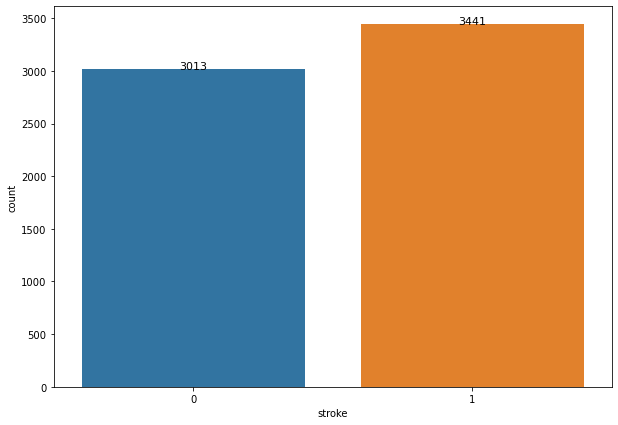

In [36]:
countplt, ax = plt.subplots(figsize = (10,7))
ax =sns.countplot(ytrain_sampled);

# show count (+ annotate)
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

Finalmente, gracias a este apartado en nuestro dataset tenemos suficientes instancias de la *clase positiva* y balanceamos el conjunto de datos resolviendo el problema del desbalanceo.

<a name="item5"></a>
## 2.Generalización

Una vez hemos balanceado el conjunto de entrenamiento iteramos por segunda vez nuestro algoritmo y evaluamos los resultados.

In [37]:
LogReg=LogReg.fit(Xtrain_sampled,ytrain_sampled.ravel())

# Cálculo de la media geométrica en test
predicciones=np.round(LogReg.predict_proba(X_test)[:,1].reshape(-1,1),0)
comparacion= predicciones==y_test.to_numpy().reshape(-1,1)   
suma=comparacion.sum()
accTest=100*suma/predicciones.size
print('Accuracy obtenido con el conjunto de datos sin modificar: {}'.format(accTest))

Accuracy obtenido con el conjunto de datos sin modificar: 73.0829420970266


In [38]:
precision = precision_score(y_test, predicciones)
recall = recall_score(y_test, predicciones)
matriz_de_decision=confusion_matrix(y_test, predicciones)

print('Precisión de nuestro modelo',precision)
print ('Recall de nuestro modelo ', recall)

f2=F_Score(recall,precision,2)
print('F Sore de nuestro modelo ',f2)

Precisión de nuestro modelo 0.15803108808290156
Recall de nuestro modelo  0.7625
F Sore de nuestro modelo  0.4320113314447592


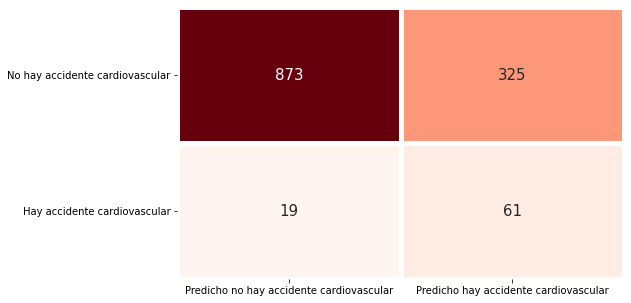

In [39]:
plt.figure(figsize = (8, 5))
sns.heatmap(matriz_de_decision, cmap = 'Reds', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No hay accidente cardiovascular', 'Hay accidente cardiovascular'],
            xticklabels = ['Predicho no hay accidente cardiovascular', 'Predicho hay accidente cardiovascular'])
plt.yticks(rotation = 0)
plt.show()

Observamos que después de aplicar la técnica de *SMOTE con ENN* para los datos estandarizados baja nuestro accuracy, esto nos podría confundir, ya que en principio que baje el accuracy no es una buena señal. Sin embargo, como estamos en un problema médico es preferible favorecer el **recall** que la **precisión** a la hora de predecir tal y como hemos explicado en . Por lo tanto, nos fijamos en si hemos logrado mejorar el valor del **F Score**.

In [40]:
print('Diferencia del F Score: {}'.format(f2-f1))

Diferencia del F Score: 0.41643500745722023


Observamos que gracias a nuestro muestreo en [Selección de instancias y balanceo del modelo](#item3), el conjunto de datos de entrenamiento que obtenemos provoca una mejora considerable en el **F Score**, por lo que logramos el objetivo.

<a name="item4"></a>
## Selección de variables del modelo

Por último, vamos a buscar las variables mas relevantes del modelo para intentar mejorar nuestro objetivo. Nuestra intención es eliminar las variables redundantes e irrelevantes, dado que estas pueden confundir al algoritmo de clasificación.

Para ello comenzaremos analizando la correlación de todas las variables que tenemos en el conjunto de entrenamiento *train*.

Comenzaremos por calcular la matriz de correlación para observar la correlación entre las variables.

 *Comentar que la variable genderOther no la mostramos en las siguientes gráficas debido a que en el conjunto de entrenamiento no se encuentra ningún individuo con esa caracteristica.*

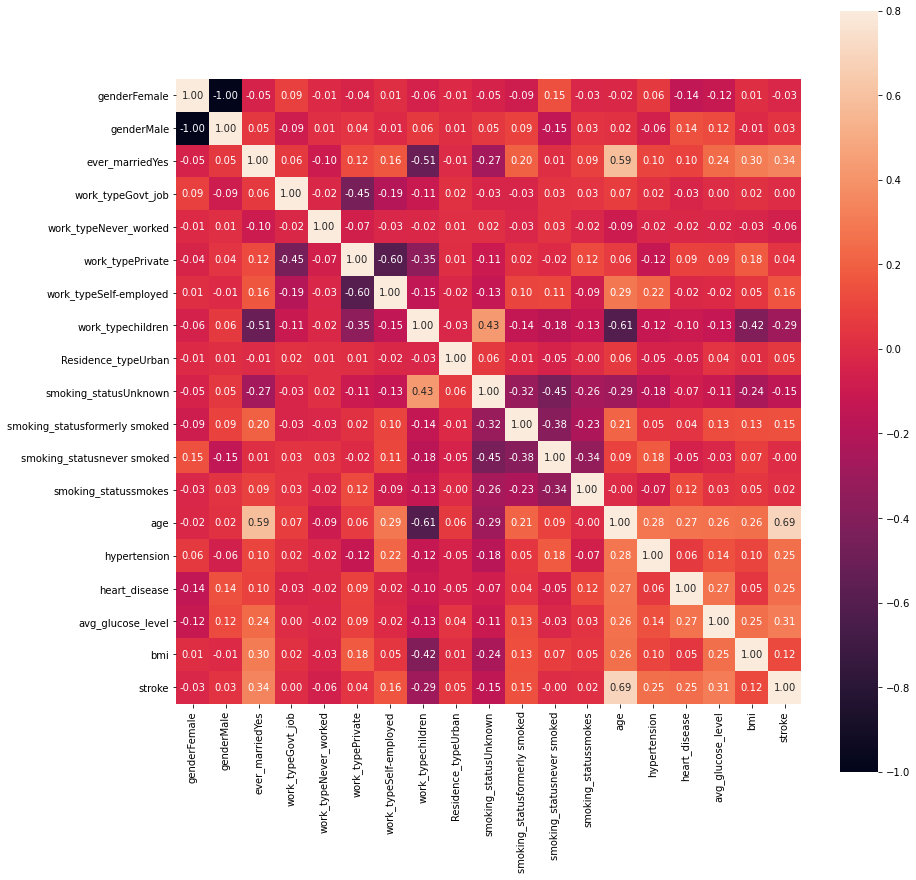

In [41]:
import seaborn as sns

data_modificado=pd.concat((Xtrain_sampled,ytrain_sampled), axis = 1)
data_modificado.columns = data_transform.columns
data_modificado.drop('genderOther', axis=1, inplace=True)#eliminamos
correlaciones_transform=data_modificado.corr()

fig, axes = plt.subplots(figsize=(14,14))
sns.heatmap(correlaciones_transform, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10});

Dada la gran cantida de variables para facilitar la visualización, mostramos una gráfica con la última columna ya que indica la correlación de cada variable con la variable a predecir.

Minimo:  -0.2910741582896458  Maximo:  0.6938963159431311


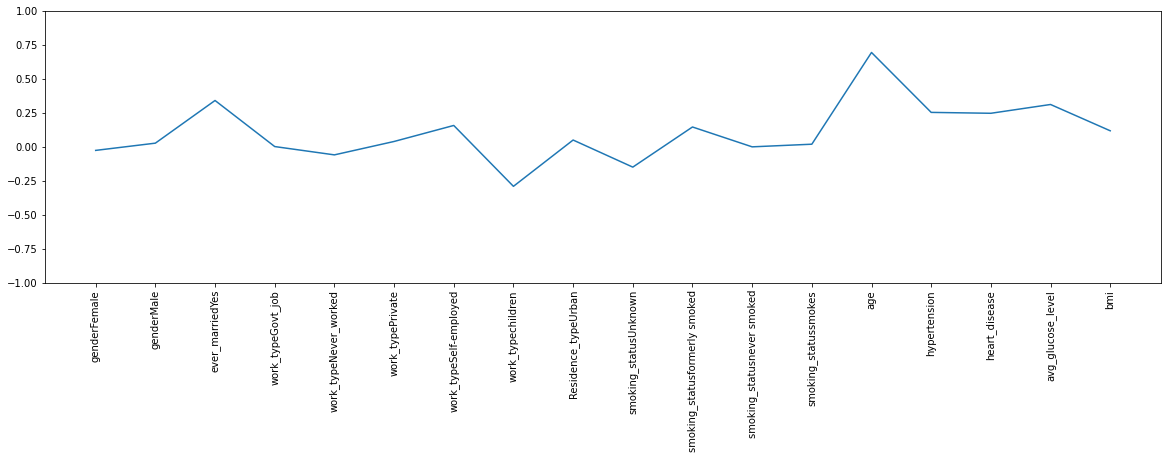

In [42]:
# nos quedamos con la última columna del DataFrame 
    # (todas las filas de correlaciones menos la última porque es la correlación de la variable a predecir consigo misma)
correlacionConClase =correlaciones_transform.iloc[:-1,-1]
# Mostramos el valor de correlación mínimo y máximo
descripcion= correlacionConClase.describe()
minimo,maximo=descripcion.loc['min'],descripcion.loc['max']
print('Minimo: ',minimo,' Maximo: ',maximo)
# Mostramos una figura que muestre la correlación entre las variables de entrada y de salida
fig = plt.figure(figsize=(20,5))
ax = fig.gca()
ax.plot(range(correlacionConClase.shape[0]), correlacionConClase)
ax.set_xticks(range(correlacionConClase.shape[0]))
ax.set_xticklabels(data_modificado.columns[:-1], rotation='90')
plt.ylim(-1,1)
plt.show()

A la hora de analizar las gráficas anteriores hay que tener en cuenta que nos interesan variables que esten correlacionadas positivamente con la variable a predecir y que al mismo tiempo sea una variable no redundante. Por ejemplo, la variable *age* puede ser una variable con gran importancia con la variable respuesta dada la correlación entre ambas, sin embargo al seleccionar esta caracteristica habría variables como el estado civil o poseer hipertensión que quedarían en un segundo plano como caracteristicas redundantes.

Para hacer esta selección de variables aplicaremos varios *filtros* y *wrappers* con los que iremos evalueando nuestro algoritmo y finalmente tomaremos la técnica que mejor resultado nos proporcione en el **F score**. Hacemos uso de las siguientes técnicas:

*  Filtro T test
*  PCA
*  Filtro ANOVA
*  Wrapper SBS

*Para hacer uso del filtro T test sera necesaria la construcción del filtro tal y como hacemos en el siguiente apartado de código.*

In [43]:
from sklearn.base import TransformerMixin

class t_test(TransformerMixin):

    def __init__(self, tipoSeleccion = 'Kbest', K = None, percentil = None):
        self.tipoSeleccion = tipoSeleccion
        self.K = K
        self.percentil = percentil
        
    def fit(self, X_train, y_train):
        # Variables para almacenar el número de ejemplos, las medias, desviaciones estándar y variazas
            # de los ejemplos según su clase (clase 0: C0 y clase 1: C1)
        N0 = len(X_train[y_train == 0])
        N1 = len(X_train[y_train == 1])
        mediasC0 = X_train[y_train == 0].describe().loc['mean']
        mediasC1 = X_train[y_train == 1].describe().loc['mean']
        stdsC0 = X_train[y_train == 0].describe().loc['std']
        stdsC1 = X_train[y_train == 1].describe().loc['std']
        varsC0 = stdsC0**2
        varsC1 = stdsC1**2
        # Propiedad para almacenar el valor t de cada variable
        self.t = np.abs(mediasC0 - mediasC1)/np.sqrt(np.abs(varsC0/N0 + varsC1/N1))
        return self

    def transform(self, X):
        # Variable para almacenar los índices de las variables ordenadas de acuerdo al valor t
        indices = np.argsort(self.t).values[::-1]
        # Variable para almacenar True en caso de que la variable se seleccione y False en caso contrario
            # de aceurdo al tipo de selección especificdo en el constructor
        booleanos = np.zeros(X.shape[1],).astype('bool')
        if self.tipoSeleccion == 'Kbest':
            booleanos[:self.K] = True
        elif self.tipoSeleccion == 'percentil':
            booleanos[:int(np.round(X.shape[1]*(self.percentil),0))] = True
        self.var=indices[booleanos]
        return X.iloc[:,indices[booleanos]]
    
    # Método para asignar los valores de los híper-parámetros y que, de este modo, 
    # podamos aplicar GridSearchCV sobre un objeto de esta clase
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    def get_var(self):
        return self.var

Una vez hemos cargado  la técnica *T test*, procedemos a evaluar todas las posibles técnicas y seleccionar la que mejor resultado nos de en el **F Score**.

In [44]:
from sklearn import neighbors
from imblearn.metrics import geometric_mean_score
from imblearn.pipeline import Pipeline
import imblearn.combine as hib
import imblearn.under_sampling as us
from sklearn.decomposition import PCA
from sklearn import feature_selection
from sklearn import linear_model

pca = PCA(n_components=int(np.round(Xtrain_sampled.shape[1]*0.5,0)),svd_solver='full') 
sbs = feature_selection.RFE(linear_model.LogisticRegression(solver='lbfgs'), n_features_to_select=10, step=1)
ttest = t_test(K = 10)
anova = feature_selection.SelectPercentile(feature_selection.f_classif, percentile = 30)

listaMetodosSV = ['Técnica PCA', 'Wrapper SBS', 'Filtro T test', 'Filtro Anova']
listaTecnicasSV = [pca,sbs,ttest, anova]
# Se crea una lista para almacenar el resultado de test de cada técnica de
#muestreo con KNN, almacenamos el recall de las predicciones obtenidas con KNN!!
listaF_ScoreSV = []
# Por cada técnica se cogen los datos de entrada y de salida (muestreados para realizar el aprendizaje)

for nombre, metodo in zip(listaMetodosSV, listaTecnicasSV):
    # Generamos la pipeline con los componentes adecuados
    pipe = Pipeline([(nombre,metodo),('Modelo Logistico', LogReg)])
    # Entrenamiento de la pipeline
    pipe = pipe.fit(Xtrain_sampled,ytrain_sampled)
    # Precicción de los datos de entrenamiento 
    prediccionesTrain = pipe.predict(Xtrain_sampled)
    # Cálculo de la media geométrica en entrenamiento
    accTrain = geometric_mean_score(ytrain_sampled, prediccionesTrain)
    # Se imprime el resultado en train: mostrad el nombre de la técnica y su rendimiento
    print('\nResultado en train utilizando la {}: {}'.format(nombre,accTrain))
    # Precicción de los datos de test 
    prediccionesTest = pipe.predict(X_test)
    # Cálculo de la media geométrica en test
    accTest = geometric_mean_score(y_test, prediccionesTest)
    # Se imprime el resultado en test: mostrad el nombre de la técnica y su rendimiento
    print('Resultado en test utilizando la {}: {}'.format(nombre,accTest))        
        
    # Se añade a la lista el resultado de test a la lista listaRecall
    precision = precision_score(y_test, prediccionesTest)
    recall = recall_score(y_test, prediccionesTest)
    
    f_score=F_Score(recall,precision,2)
    listaF_ScoreSV.append(f_score)
    
    print('Precision obtenido en test utilizando la {}: {}'.format(nombre,precision))     
    print('Recall obtenido en test utilizando la {}: {}'.format(nombre,recall)) 
    print('F Score obtenido en test utilizando la {}: Rendimiento: {}'.format(nombre,f_score)) 

#for i in np.where(listaF_ScoreSV==max(listaF_ScoreSV))[0]:    
#    print('\n\nLa mejor tecnica es : {}.'.format(listaMetodosSV[i]))
print('\n\nLa mejor tecnica es : {}.'.format(listaMetodosSV[int(np.where(listaF_ScoreSV==max(listaF_ScoreSV))[0])]))


Resultado en train utilizando la Técnica PCA: 0.7782797070320335
Resultado en test utilizando la Técnica PCA: 0.7317763736974817
Precision obtenido en test utilizando la Técnica PCA: 0.1342685370741483
Recall obtenido en test utilizando la Técnica PCA: 0.8375
F Score obtenido en test utilizando la Técnica PCA: Rendimiento: 0.4090354090354091

Resultado en train utilizando la Wrapper SBS: 0.8494683719123307
Resultado en test utilizando la Wrapper SBS: 0.7489140719369893
Precision obtenido en test utilizando la Wrapper SBS: 0.15776081424936386
Recall obtenido en test utilizando la Wrapper SBS: 0.775
F Score obtenido en test utilizando la Wrapper SBS: Rendimiento: 0.43478260869565216

Resultado en train utilizando la Filtro T test: 0.8533986188550386
Resultado en test utilizando la Filtro T test: 0.7663765752499353
Precision obtenido en test utilizando la Filtro T test: 0.163727959697733
Recall obtenido en test utilizando la Filtro T test: 0.8125
F Score obtenido en test utilizando la Fi

C:\Users\unaig\anaconda3\envs\py38ml\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [2] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\unaig\anaconda3\envs\py38ml\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [45]:
tecnica=listaTecnicasSV[int(np.where(listaF_ScoreSV==max(listaF_ScoreSV))[0][0])]

tecnica.fit(Xtrain_sampled,ytrain_sampled)
Xtrain_finall = tecnica.transform(Xtrain_sampled)
ytrain_finall = ytrain_sampled.copy()
Xtest_finall = tecnica.transform(X_test)
ytest_finall=y_test.copy()
print('Numero de variables iniciales: {}\nNumero de variables actuales: {}'.format(Xtrain_sampled.shape[1],Xtrain_finall.shape[1]))

Numero de variables iniciales: 19
Numero de variables actuales: 10


Observamos que la técnica de selección de variables que mejor resultado nos proporciona es el filtro *T test* con el que reducimos a 10 las variables a utilizar las cuales mostramos a continuación.

In [46]:
print(data_transform.columns[tecnica.get_var()])

Index(['smoking_statussmokes', 'genderOther', 'heart_disease',
       'work_typeSelf-employed', 'age', 'hypertension', 'work_typePrivate',
       'Residence_typeUrban', 'smoking_statusUnknown', 'avg_glucose_level'],
      dtype='object')


Observar que con el filtro T test nos quedamos con las siguientes caracteristicas de cada individuo:

* El individuo fuma o no.
* Si es de genero no binario.
* Si el individuo ha tenido o no un ataque al corazón.
* Si el individuo esta trabajando o no.
* La edad del individuo.
* Si sufre o no hipertensión.
* Si el individuo trabajo o no en el ambito privado.
* Si vive en zona urbana o no.
* Si no se sabe la situación de fumar del individuo.
* El nivel medio de glucosa del individuo.

*Cabe comentar que variables que estaban correlacionadas con la variable respuesta como el estado civil no se han incluido dada su alta correlación con la edad.*

## 3.Generalización

Para acabar, despues de hacer la última modificación en el conjunto de entrenamiento, itermos por última vez nuestro algoritmo y analizamos los resultados finales.

In [47]:
LogReg=LogReg.fit(Xtrain_finall,ytrain_finall.ravel())
print('Continuamos con la configuracion de los datos creada con el {}'.format(listaMetodos[int(np.where(listaF_Score==max(listaF_Score))[0][0])]
))
# Cálculo de la media geométrica en test
predicciones=np.round(LogReg.predict_proba(Xtest_finall)[:,1].reshape(-1,1),0)
comparacion= predicciones==ytest_finall.to_numpy().reshape(-1,1)   
suma=comparacion.sum()
accTest=100*suma/predicciones.size
print('Accuracy obtenido con el conjunto de datos sin modificar: {}'.format(accTest))

Continuamos con la configuracion de los datos creada con el Técnica híbrida SMOTE con ENN
Accuracy obtenido con el conjunto de datos sin modificar: 72.84820031298905


In [48]:
precision3 = precision_score(ytest_finall, predicciones)
recall3 = recall_score(ytest_finall, predicciones)
matriz_de_decision=confusion_matrix(ytest_finall, predicciones)

print('Precisión de nuestro modelo',precision3)
print ('Recall de nuestro modelo ', recall3)
f3=F_Score(recall,precision,2)
print('F Sore de nuestro modelo ',f3)

Precisión de nuestro modelo 0.163727959697733
Recall de nuestro modelo  0.8125
F Sore de nuestro modelo  0.43600562587904357


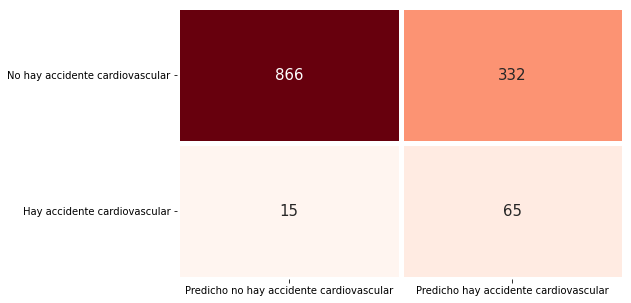

In [49]:
plt.figure(figsize = (8, 5))
sns.heatmap(matriz_de_decision, cmap = 'Reds', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No hay accidente cardiovascular', 'Hay accidente cardiovascular'],
            xticklabels = ['Predicho no hay accidente cardiovascular', 'Predicho hay accidente cardiovascular'])
plt.yticks(rotation = 0)
plt.show()

In [50]:
print('Diferencia del F Score: {}'.format(f3-f2))

Diferencia del F Score: 0.003994294434284396


Observamos que gracias a nuestra selección de variables en [Selección de variables del modelo](#item4), el conjunto de datos de entrenamiento que obtenemos provoca una mejora pequeña en el **F Score**, sin embargo logramos cumplir conn el objetivo y mejoramos el **F Score**. Además, si nos fijamos en los resultados de [2.Generalización](#item5) obtenemos no solo una mejora del **recall** si no que también mejoramos la **pracisión**.

## Conclusiones

Finalmente, concluimos con una breve conclusión en base a todos los procedimientos que hemos seguido.

In [51]:
print('Diferencia entre el resultado final e inicial en la precisión: {}'.format(precision3-precision1))
print('Diferencia entre el resultado final e inicial en la recall: {}'.format(recall3-recall1))
print('Diferencia entre el resultado final e inicial en la F score: {}'.format(f3-f1))

#imprimir tambien los finales y hablar de las tecnicas que se han seleccionado y lo que hacen...
#explicar porque primero outliers y luego nulos...

Diferencia entre el resultado final e inicial en la precisión: -0.836272040302267
Diferencia entre el resultado final e inicial en la recall: 0.8
Diferencia entre el resultado final e inicial en la F score: 0.4204293018915046
